<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Shapley Additive Explanations (SHAP)

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

shap.initjs()

## SHAP on a regression task

In [2]:
# Load the dataset
df = sns.load_dataset('tips')
df['tip_pct'] = df['tip']/df['total_bill']
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


In [3]:
# Create target variable as tip percentage
y = df.loc[:,'tip_pct']

# Encode categorical features
X = df[['sex','smoker','day','time','size']]
for f in ['sex','smoker','day','time']:
    X.loc[:,f] = X.loc[:,f].astype('category').cat.codes

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [4]:
# Interpret using the coefficients of the linear regression model with standardized data
scaler = StandardScaler()
std_Xtrain = scaler.fit_transform(X_train)
lin_std_model = LinearRegression()
lin_std_model.fit(std_Xtrain,y_train)
coef = lin_std_model.coef_
intercept = lin_std_model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X_train.columns)])
print(equation)

y = 0.158 + -0.001*sex + -0.002*smoker + 0.015*day + -0.017*time + -0.009*size


In [5]:
# Train a linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)
test_preds = lin_model.predict(X_test)

# Create SHAP model using model-agnostic KernelExplainer
explainer = shap.KernelExplainer(lin_model.predict, X_train)

print('For observation 0:')
print('Model prediction is: {:.3f}'.format(test_preds[0]))
# View explanation for a single observation from the test set
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[0,:])

Using 170 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


For observation 0:
Model prediction is: 0.146


  0%|          | 0/74 [00:00<?, ?it/s]

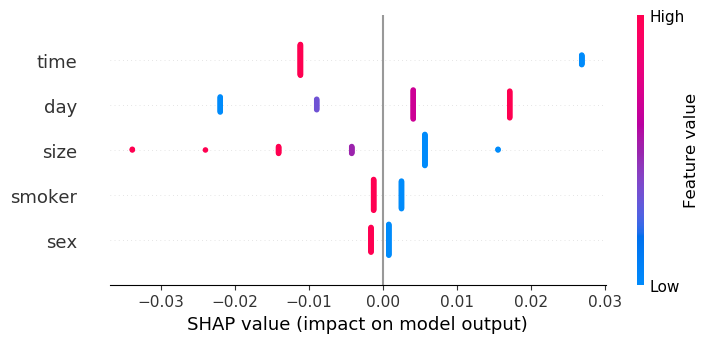

In [6]:
# Plot the impact of features on test set predictions
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## SHAP on Random Forest

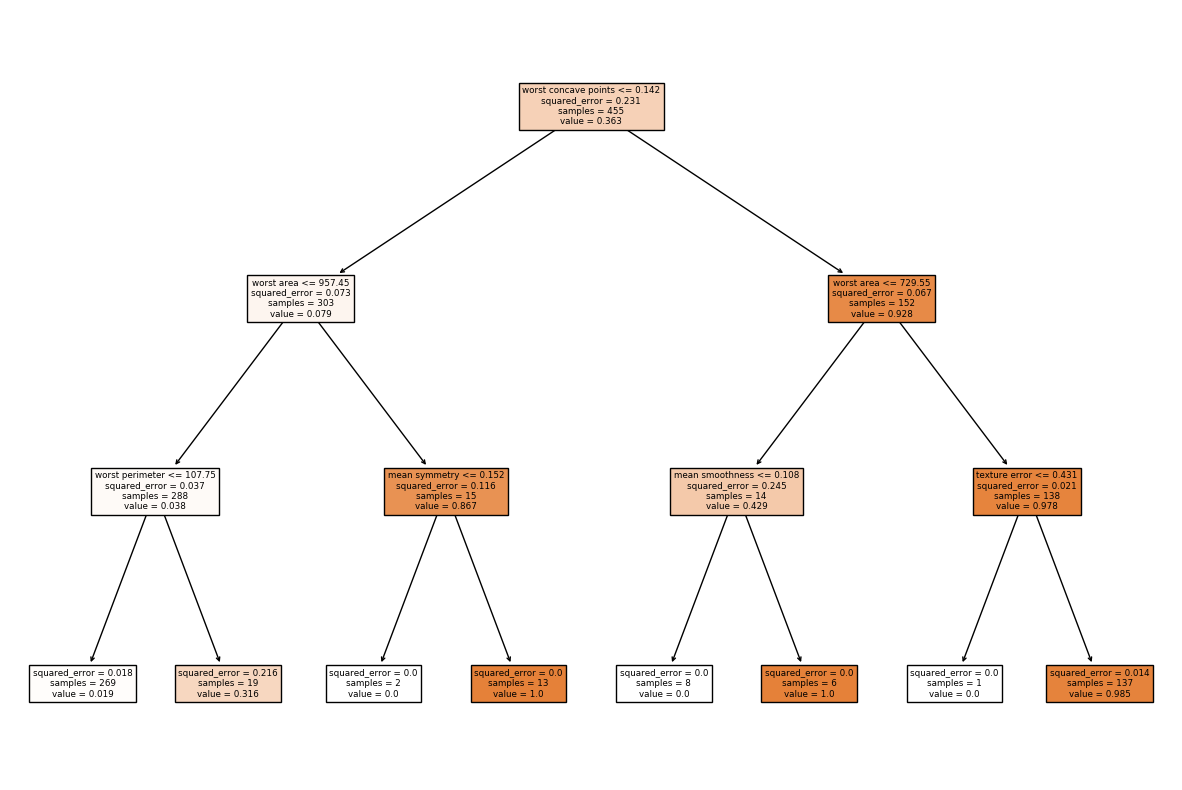

In [24]:
# Train a single tree model
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_train,y_train)

# Visualize the decision tree
plt.figure(figsize=(15,10))
plot_tree(tree_model,feature_names=X.columns,class_names=y.unique(),filled=True)
plt.show()

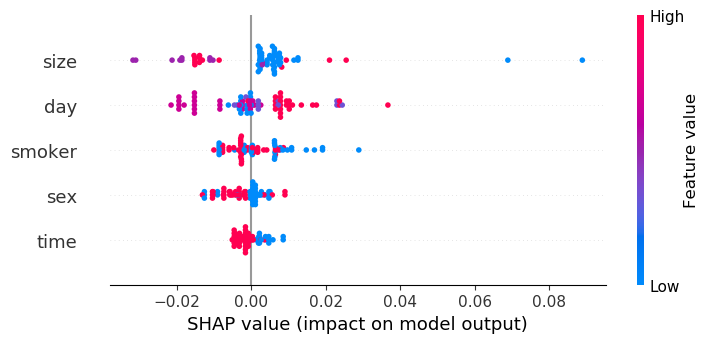

In [8]:
# Train random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rf_model.fit(X_train, y_train)

# Create SHAP model using TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# Generate plot showing impact of features on test set predictions
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


## SHAP on a classification task

In [15]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

In [16]:
# Train a logistic regression model
log_model = LogisticRegression(penalty='none')
log_model.fit(X_train,y_train)
test_preds = log_model.predict(X_test)
acc_score = accuracy_score(y_test,test_preds)
print('Accuracy is {:.3f}'.format(acc_score))

Accuracy is 0.939


In [17]:
# Explain all the predictions in the test set
f = lambda x: log_model.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))
explainer = shap.Explainer(f,med)
shap_values = explainer(X_test)

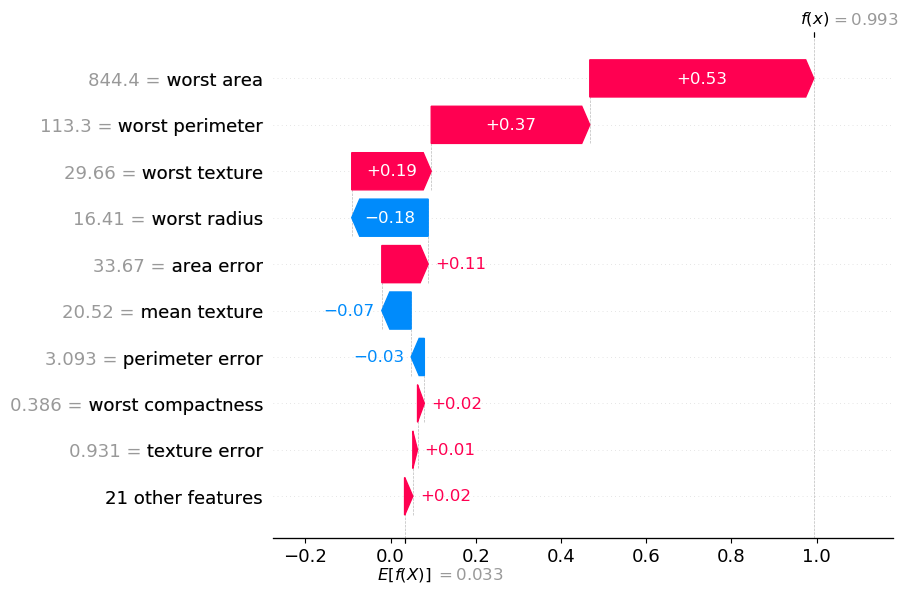

In [18]:
# View explanation for a single observation from the test set
shap.plots.waterfall(shap_values[0])

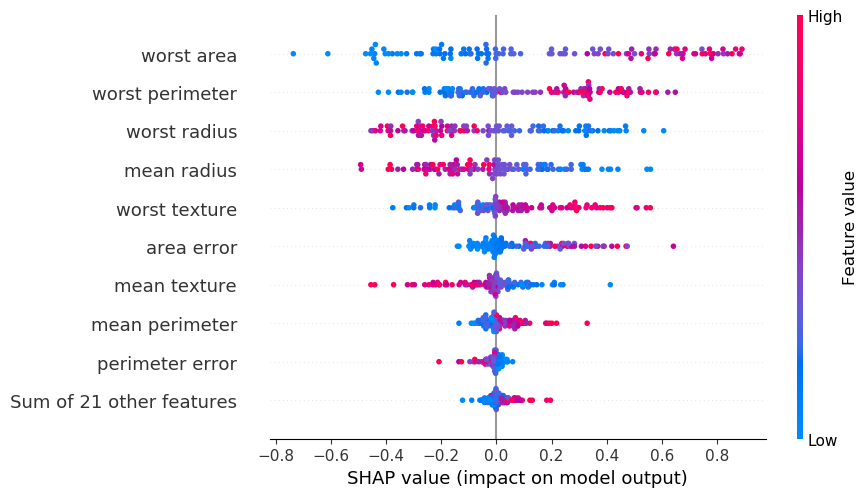

In [14]:
# View impact of features over entire test set
# Features are sorted by sum of magnitude across all samples
shap.plots.beeswarm(shap_values)